In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

## 1. Variance Threshold

Le but de cette méthode est de séléctionner les variables au dessus d'un certain seuil de variance car les features qui ne varient pas, sont quelque part inutile.

In [2]:
from sklearn.feature_selection import VarianceThreshold

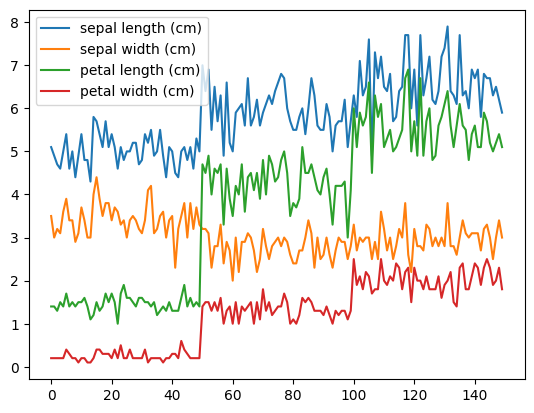

In [3]:
from sklearn.datasets import load_iris

iris = load_iris()
X = iris.data
y = iris.target

plt.plot(X)
plt.legend(iris.feature_names)

In [4]:
X.var(axis=0)

array([0.68112222, 0.18871289, 3.09550267, 0.57713289])

On peut déterminer les features à enlever.

In [5]:
selector = VarianceThreshold(threshold=0.2)
selector.fit(X)

VarianceThreshold(threshold=0.2)

In [6]:
selector.get_support()

array([ True, False,  True,  True])

Permet de faire du boolean indexing pour retrouver le nom des variables séléctionnés

In [7]:
np.array(iris.feature_names)[selector.get_support()]

array(['sepal length (cm)', 'petal length (cm)', 'petal width (cm)'],
      dtype='<U17')

In [8]:
selector.variances_

array([0.68112222, 0.18871289, 3.09550267, 0.57713289])

## 2. SelectKBest

Il est important de connaitre les test de dépendances pour utiliser celui qui sera le mieux pour notre problème. Rappelle que plus une variable varie, plus elle est importante pour notre model.

In [9]:
from sklearn.feature_selection import SelectKBest, chi2, f_classif

In [10]:
chi2(X, y)

(array([ 10.81782088,   3.7107283 , 116.31261309,  67.0483602 ]),
 array([4.47651499e-03, 1.56395980e-01, 5.53397228e-26, 2.75824965e-15]))

Le test de chi2 est un test statistique. Il retourne deux tableaux numpy. Le premier représente le scoring, plus élévé, plus la dépendence entre X et y est élevé.
Le deuxième, on retrouve les valeurs de probabilités.

Le séléctor prend en paramètre le test à effectué et k représentant le nombre de voisins.

In [11]:
selector = SelectKBest(f_classif, k=2)
selector.fit(X, y)
selector.scores_

array([ 119.26450218,   49.16004009, 1180.16118225,  960.0071468 ])

In [12]:
np.array(iris.feature_names)[selector.get_support()]

array(['petal length (cm)', 'petal width (cm)'], dtype='<U17')

In [16]:
from sklearn.feature_selection import RFECV, SelectFromModel
from sklearn.linear_model import SGDClassifier

SGDClassifier est un méta-transformer puisqu'il possède lui même un estimator.
Du coup on peut utiliser l'attribut coef.
Le résultat est une matrice 4x3. On a une matrice (4, 150) et on à un y (150,) mais nous avons 3 classes, nous attendons donc une matrice (150, 3).

Du coup, pour faire un produit matriciel pour ce retourver avec une matrice (150,3) => y il faut faire le produit matriciel de X (150, 4) @ theta(4, 150) pour ce retrouver avec la matrice y (150, 3) que l'on voulait.

Il y a trois classes car l'encodage OneHot est passé par ici, donnant 3 variables y1, y2, y3.

In [32]:
selector = SelectFromModel(SGDClassifier(random_state = 0), threshold='mean')
selector.fit_transform(X, y)
selector.estimator_.coef_ # Matrice théta 3x4 avec les valeurs des 4 features par rapport à la matrice y représenté sous 3 classes.
selector.estimator_.coef_.mean() # Retourne -0.9, il va donc séléctionner toutes les valeurs au dessus.
selector.estimator_.coef_.mean(axis=0) # Il va donc séléctionner la dernière et avant dernière colonne.
# selector.get_support() # Affiche les résultats en booléan indexing.


array([-26.04295373, -35.56158609,  37.87734374,  19.83872585])

## 3. Recursive feature Elimination

C'est un algo récursif, il existe aussi RFE, qui est le même algo mais sans la cross validation.

Le principe est le suivant, on estime le coef des différentes variable, le paramètre step définit combien on en élimine à chaque itération. Première itération il définit la plus faible qu'il enleve, ensuite il les réentraine dans l'estimateur et rééfectue le trie jusqu'à atteindre le paramètre min_features_to_select.

Ce qu'il faut comprendre c'est que les variables sont réentrainés à chaque boucle

In [42]:
selector = RFECV(SGDClassifier(random_state=0), step=1, min_features_to_select=2, cv=5)
selector.fit(X, y)
print(selector.ranking_) # Retourne le classement des différentes variables, ici la première variable sera retiré.
print(selector.cv_results_) 

[2 1 1 1]
{'mean_test_score': array([0.8       , 0.84666667, 0.77333333]), 'std_test_score': array([0.10540926, 0.08055364, 0.1289272 ]), 'split0_test_score': array([0.73333333, 0.73333333, 1.        ]), 'split1_test_score': array([0.93333333, 0.8       , 0.8       ]), 'split2_test_score': array([0.86666667, 0.9       , 0.76666667]), 'split3_test_score': array([0.83333333, 0.83333333, 0.63333333]), 'split4_test_score': array([0.63333333, 0.96666667, 0.66666667]), 'n_features': array([2, 3, 4])}


On peut voir que cv résulte donne des infos sur l'entrainement. Première itération, il a obtenu un score de 80% et éliminé 1 variables. Il s'est réentrainé et à obtenu un score de 84%, à encore éliminé une variable. Puis il vu qu'en enlevant cette variale le scoring était moin élévé donc il l'a réinjecté. C'est pour ça qu'on voit qu'il y a 3 variables séléctionné alors qu'il y avait 3 itérations.

In [25]:
np.array(iris.feature_names)[selector.get_support()]

array(['sepal width (cm)', 'petal length (cm)', 'petal width (cm)'],
      dtype='<U17')

## 4. SelectFromModel

In [0]:
from sklearn.feature_selection import SelectFromModel

In [27]:
X = iris.data
y = iris.target
selector = SelectFromModel(SGDClassifier(random_state=0), threshold='mean')
selector.fit(X, y)
selector.estimator_.coef_

array([[  8.64029104,  27.2851296 , -40.01819009, -17.73533424],
       [ -5.48888269, -58.79616709,  22.88584985, -54.14457159],
       [-81.28026953, -75.17372078, 130.76437145, 131.39608339]])

In [29]:
np.array(iris.feature_names)[selector.get_support()]

array(['petal length (cm)', 'petal width (cm)'], dtype='<U17')